#Perform standard offline calculations for POD
-----------------------------------------------
##POD for the solution
1. Read in solution snapshots, $\mathbf{S} \in R^{N \times n_{s}}$
2. Compute SVD for solution snapshots, $\mathbf{S} = \mathbf{U}\mathbf{\Sigma} \mathbf{W}^T$. Save $\mathbf{U}$, diag($\Sigma$) to separate files
3. Calculate which level of truncation gives you 99.99\% of the 'energy' from $\mathbf{S}$
4. Define $\tilde{\mathbf{U}} = \mathbf{U}_{i,j}, 1 \le i \le N, 1 \le j \le m$. Save $\tilde{\mathbf{U}}$ to a file.


 

In [1]:
#some preliminaries
import numpy as np
import scipy
from proteus.iproteus import *
from proteus import deim_utils,Archiver

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
#read snapshots
sim_archive = "burgers_1d"
archive = Archiver.XdmfArchive(".",sim_archive,readOnly=True)

#should be able to find this out with a query or something
n_s = 100; soln_name='u'
S = deim_utils.read_snapshots(archive,n_s+1,soln_name)
U, s, W = np.linalg.svd(S, full_matrices=False)

print 'SVD for solution done!'
np.savetxt('SVD_basis', U, delimiter=' ')
np.savetxt('Singular_values', s, delimiter=' ')

m = 10

SVD for solution done!


In [4]:
np.savetxt('SVD_basis_truncated_{0}'.format(m), U[:,0:m], delimiter=' ')

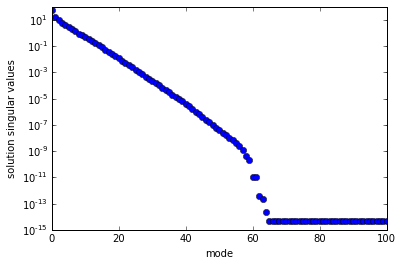

In [5]:
#plot the singular values
plt.semilogy(s,'o')
plt.xlabel('mode'); plt.ylabel('solution singular values')

##POD for the nonlinear snapshots
1. Read in solution snapshots, $\mathbf{S}_f \in R^{N \times n_{s}}$
2. Compute SVD for solution snapshots, $\mathbf{S}_f = \mathbf{U}_f\mathbf{\Sigma}_f \mathbf{W}_f^T$. Save $\mathbf{U}_f$, diag($\Sigma_f$) to separate files
3. Calculate which level of truncation gives you 99.99\% of the 'energy' from $\mathbf{S}$
4. Define $\tilde{\mathbf{U}}_f = \mathbf{U}_{f,i,j}, 1 \le i \le N, 1 \le j \le m_f$. Save $\tilde{\mathbf{U}}_f$ to a file.


In [6]:
nonlin_name='spatial_residual0'
Sf = deim_utils.read_snapshots(archive,n_s+1,nonlin_name)
Uf,sf,Vf = np.linalg.svd(Sf,full_matrices=False)

print 'SVD for spatial residual done!'
np.savetxt('Fs_SVD_basis', Uf, delimiter=' ')
np.savetxt('Fs_Singular_values', sf, delimiter=' ')

mf = 10

SVD for spatial residual done!


In [7]:
#override truncation level if desired
set_manual_hyper_modes=False
if set_manual_hyper_modes:
    mf = 73

In [8]:
Vf.shape

(101, 101)

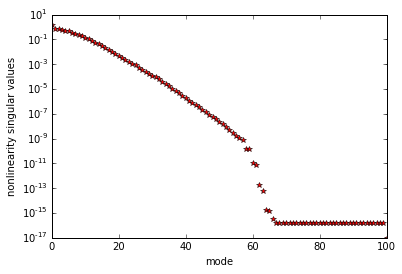

In [9]:
#plot the singular values
plt.semilogy(sf,'r*')
plt.xlabel('mode'); plt.ylabel('nonlinearity singular values')

##DEIM for evaluation of the nonlinearity
1. Set $\vec{\rho}, \tilde{\mathbf{U}}_f \leftarrow \mbox{DEIM}(m_f,\tilde{\mathbf{U}}_f)$
2. Write out indices $\rho$ to a file- pick $m$, dimension for $F$ reduced basis $\mathbf{U}_m$
3. Formally build $\mathbf{P}$ from $\rho$ as 
    $$
    \mathbf{P} = [\vec e_{\rho_1},\vec e_{\rho_2},\dots,\vec e_{\rho_m}]
    $$
   Really just save $\vec{\rho}$ as a vector for evaluations
4. Invert $\mathbf{P}^T\tilde{\mathbf{U}}_f$
5. Set $\mathbf{Q}=\tilde{\mathbf{U}}_f(\mathbf{P}^T\tilde{\mathbf{U}}_f)^{-1}$
6. Save $\mathbf{Q}$ to a file.

During evolution
1. Project to fine grid $\vec v = \tilde{\mathbf{U}} \vec z$
2. Evaluate $\vec F(\tilde{\mathbf{U}}\vec z)$ at indices in $\vec \rho \rightarrow \vec c$
3. Apply DEIM interpolant $\tilde{\vec F} = \tilde{\mathbf{U}}^T\mathbf{Q}\vec c$
4. Use $\tilde{\vec F}$ in evaluation of reduced system


In [10]:
mf

10

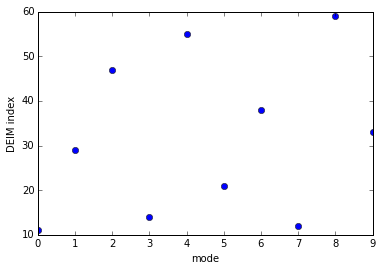

In [11]:
rho,Q = deim_utils.deim_alg(Uf,mf)
plt.plot(rho,'o')
plt.xlabel('mode'); plt.ylabel('DEIM index')

In [12]:
np.savetxt('Fs_SVD_basis_truncated_{0}'.format(mf), Uf[:,0:mf], delimiter=' ')
np.savetxt('Q_DEIM_truncated_{0}'.format(mf),Q,delimiter=' ')
np.savetxt('DEIM_indices_{0}'.format(mf),rho,delimiter=' ',fmt='%d')


In [13]:
Q_reload = np.loadtxt('Q_DEIM_truncated_10')
np.max(Q_reload-Q)

0.0

##Now actually try gappy POD for evaluating nonlinearity

The process as I understand it for gappy pod is

1. Compute $M$ snapshots for high dimensional nonlinear function 
$$
\mathbf{S} = [\vec f^1, \vec f^2, \dots, \vec f^M] \in \Re^{n \times M} 
$$
2. Compute standard POD basis for snapshots
$$
\mathbf{S} = \mathbf{U}_F\mathbf{\Sigma}_F\mathbf{W}_F^T
$$
3. Pick a truncation level for basis, $m$
3. Pick $k$ indices for sampling from nonlinear function. DEIM will give us $k=m$ indices. Do I want more according to Ansallem slides? Is the Wilcox procedure different/better?
$$
\mathcal{I} = \{i_1,i_2,\dots,i_k\}
$$
To tie back to the DEIM formalism, we'll refer to the $k$ dimensional vector holding the entries
of $\mathcal{I}$ as $\vec \rho$.
4. Solve least-squares problem to minimize error in interpolation assuming that we are using the specified sampling indices. 
    - Define sample matrix $\mathbf{P} = [\vec e_{i_1}, \vec e_{i_2}, \dots, \vec e_{i_k}]$
    - I believe we technically solve the following problem at each time step
    $$
    \vec c = \mbox{arg min}_{\vec y}\|\mathbf{P}^T\mathbf{U}_m\vec y - \mathbf{P}^T\vec f\|_2
    $$
 
The solution to this least squares minimization problem is 

- Define $\mathbf{M} = \mathbf{P^T}\mathbf{U}_m \in \Re^{k \times m}$
- Perform SVD of $\mathbf{M} = \hat{\mathbf{U}}\hat{\mathbf{\Sigma}}\hat{\mathbf{W}}^T$. Here 
  $\hat{\mathbf{U}} \in \Re^{k \times k}$, $\hat{\mathbf{W}} \in \Re^{m \times m}$, and   $\hat{\mathbf{\Sigma}} \in \Re^{k \times m}$. 
   
- Define the Moore-Penrose pseudoinverse

    $$
    \mathbf{M}^{\dagger} = \hat{\mathbf{W}}\hat{\mathbf{\Sigma}}^{\dagger}\hat{\mathbf{U}}^{T}
    $$ 
    where $\hat{\mathbf{\Sigma}}^{\dagger} \in \Re^{m\times k}$ with the nonzero entries  given by
    
    $$
    \hat{\Sigma}^{\dagger}_{ii}= 1/\Sigma_{ii}, \mbox{ if } \Sigma_{ii} > 0
    $$
- set $\vec c = \mathbf{M}^{\dagger}\mathbf{P}^T\vec f$    

I believe we can compute the Moore-Penrose pseudoinverse with `numpy.linalg.pinv`  

Alternatively, we could just use numpy's least squares algorithm or the QR factorization suggested by Carlberg et al in their 2011 paper. _Note_ this $\mathbf{Q}$ is not the same as the $\mathbf{Q}$ in the final hyper-reduction approximation.

$$
\mathbf{Q}\mathbf{R} = \mathbf{M}, \ \ \mathbf{Q} \in \Re^{k,\ell}, \ \ell = \min(k,m), \mathbf{R} \in \Re^{\ell,m}
$$
solve (note we require $k \ge m$ )
$$
\mathbf{R}\vec c = \mathbf{Q}^T\mathbf{P}^T\vec f
$$

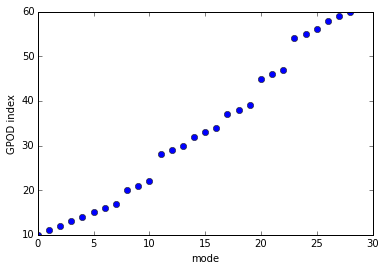

In [14]:
rho,nind,Q = deim_utils.gpod_alg(Uf,mf)
plt.plot(rho,'o')
plt.xlabel('mode'); plt.ylabel('GPOD index')

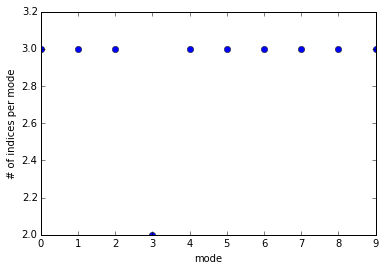

In [15]:
plt.plot(nind,'o')
plt.xlabel('mode'); plt.ylabel('# of indices per mode')

###Calculate $\mathbf{P}^T\mathbf{U}_m$ by just extracting rows in numpy 

###Then invert and set $\mathbf{P}_F=\mathbf{U}_m (\mathbf{P}^T\mathbf{U}_m)^{\dagger})$

###Note, I need to finish making the notation consistent between DEIM above and Gappy POD

In [16]:
np.savetxt('Fs_SVD_basis_truncated_{0}'.format(mf), Uf[:,0:mf], delimiter=' ')
np.savetxt('Q_GPOD_truncated_{0}'.format(mf),Q,delimiter=' ')
np.savetxt('GPOD_indices_{0}'.format(mf),rho,delimiter=' ',fmt='%d')
np.savetxt('GPOD_indexrate_{0}'.format(mf),nind,delimiter=' ',fmt='%d')

Notes from GNAT
---------------
- good rule of thumb is 99.99% of basis
- read refs [35] (Everson et al Journal of the optical society of america), [20] 346-366 (Ryckellynck D JCP 202 2005, [34], galbaly, ghattas, ijnme 2010
- implement GNAT burgers equation
- GNAT only uses snapshot strategy 0 or 1
- think about hyperreduction implementation as sample mesh
- read up on linear least squares, Moore-Penrose pseudo inverse
- recommends always having at least one sample index on inflow and outflow and at least one area that has sensitivity to input parameters that are driving snapshots